In [2]:
import os

os.environ["JAX_PLATFORM_NAME"]="cpu"

os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

os.environ["NUM_INTER_THREADS"]="1"
os.environ["NUM_INTRA_THREADS"]="1"

os.environ["XLA_FLAGS"] = ("--xla_cpu_multi_thread_eigen=false "
                           "intra_op_parallelism_threads=1")

In [3]:
import sys
sys.path = ['/fh/fast/setty_m/user/dotto/Crowding/'] + sys.path
%load_ext autoreload
%autoreload 2
%aimport mellon

In [4]:
import os
import numpy as np
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal
import pandas as pd
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

from anndata import AnnData
import scanpy as sc
import harmony
import mellon

In [5]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 150 # 150 dpi resolution
matplotlib.rcParams['image.cmap'] = 'Spectral_r' # preferred color map
matplotlib.rcParams['figure.figsize'] = [6, 6] # Square
# no bounding boxes or axis:
matplotlib.rcParams['axes.spines.bottom'] = "on"
matplotlib.rcParams['axes.spines.top'] = "off"
matplotlib.rcParams['axes.spines.left'] = "on"
matplotlib.rcParams['axes.spines.right'] = "off"
# use Arial
matplotlib.rcParams["font.sans-serif"] = ["Arial"]
matplotlib.rcParams["font.family"] = "sans-serif"
pd.set_option('display.max_columns', 1000)

# Dataset specifications

In [5]:
n_dim = 10
random_seed = 52533
sample_res = 100_000
n_samples = (20*sample_res, [
    (18*sample_res, [
        (13*sample_res, []), (17*sample_res, []), (12*sample_res, []),
    ]),
    (15*sample_res, [
        (5*sample_res, []), (7*sample_res, []),
    ]),
])

# Simulation

In [6]:
%%time
np.random.seed(random_seed)

def sample_branch(base, velocity, sample_struck, curvature=.5, var_decay=1, dens_decay=1.05, n_dim=10, branch_name='b'):
    n_draws, sub_struck = sample_struck
    scale = np.sqrt(np.sum(velocity**2))
    delta = np.random.normal(0, scale, n_dim)
    new_velo = (velocity*(1-curvature) + delta*curvature) * dens_decay
    mu = base + (new_velo/2)
    q, r = np.linalg.qr(new_velo[:, None], mode='complete')
    mr = 5e-1 * np.exp(-np.arange(n_dim)*var_decay/2) * np.abs(r[0])
    mr = np.clip(mr, 1e-4*np.abs(r[0]), None)
    bases = q*mr[None, :]
    cov = bases.dot(bases.T)
    dist = multivariate_normal(mu, cov)
    samples = dist.rvs(n_draws)
    samp_list, dist_list, draws_list = [samples, ], [dist, ], [n_draws, ]
    name_list = [np.repeat(branch_name, n_draws), ]
    new_base = base + new_velo
    for i, ss in enumerate(sub_struck):
        samples, dist, n_draws, names = sample_branch(
            new_base, new_velo, ss, curvature=curvature, var_decay=var_decay,
            n_dim=n_dim, branch_name=f'{branch_name}-{i}',
        )
        samp_list += samples
        dist_list += dist
        draws_list += n_draws
        name_list += names
    return samp_list, dist_list, draws_list, name_list
    

sample_list, distributions, draws_list, name_list = sample_branch(
    np.zeros(n_dim), np.ones(n_dim), n_samples, n_dim=n_dim,
)

samples = np.concatenate(sample_list, axis=0)
n_draws = np.array(draws_list)
total_samples = np.sum(n_draws)
print(f"Total samples = {total_samples:,}")
weigts = n_draws / total_samples
pdf = np.zeros(np.sum(n_draws))
for w, dist in zip(weigts, distributions):
    pdf += w*dist.pdf(samples)

Total samples = 10,700,000
CPU times: user 10.6 s, sys: 4.66 s, total: 15.3 s
Wall time: 15.3 s


In [7]:
sim_ad = AnnData(
    samples,
    obs=pd.DataFrame({
        'ground_truth': pdf,
        'log_ground_truth': np.log10(pdf),
        'branch_name': np.concatenate(name_list, axis=0),
    }, index=range(np.sum(n_draws))),
)
sim_ad.obs['branch_name'] = sim_ad.obs['branch_name'].astype('category')

/fh/fast/setty_m/user/dotto/mamba/envs/mellon_v2/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# Density inference

In [8]:
%%time
dest = mellon.DensityEstimator(d=3, n_landmarks=1000)
sim_ad.obs['log_density'] = dest.fit_predict(sim_ad.X)

[2023-06-12 21:05:11,623] [INFO    ] Computing nearest neighbor distances.
[2023-06-12 21:37:28,478] [INFO    ] Using covariance function Matern52(ls=14.249677859697329).
[2023-06-12 21:37:28,481] [INFO    ] Large number of 10,700,000 cells and small number of 1,000 landmarks. Consider computing k-means on a subset of cells and passing the results as 'landmarks' to speed up the process.
[2023-06-12 21:37:29,386] [INFO    ] Computing 1,000 landmarks with k-means clustering.
[2023-06-12 23:40:33,397] [INFO    ] Doing low-rank Cholesky decomposition for 10,700,000 samples and 1,000 landmarks.
[2023-06-13 00:18:42,724] [INFO    ] Estimating approximation accuracy since 10,700,000 samples are more than 10 x 1,000 landmarks.
[2023-06-13 00:49:13,361] [WARNING ] High approx. rank fraction (100.0%). Consider increasing 'n_landmarks'.
[2023-06-13 00:49:13,364] [INFO    ] Using rank 1,000 covariance representation.
[2023-06-13 00:52:49,593] [INFO    ] Running inference using L-BFGS-B.
CPU times:

In [9]:
sim_ad.obs['density'] = np.exp(sim_ad.obs['log_density'])

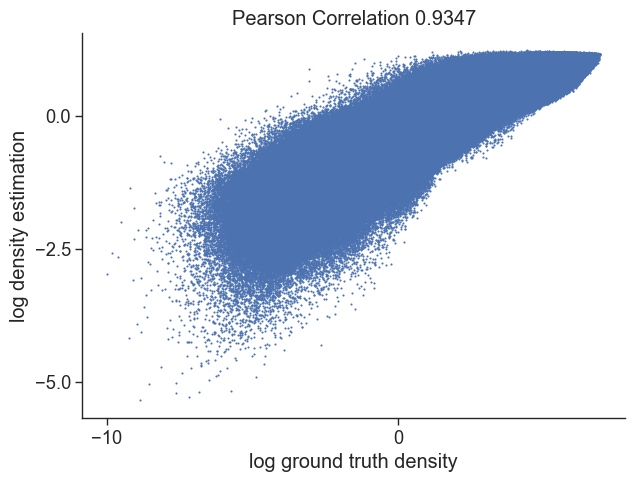

In [10]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.figsize"] = (7, 5)
x = sim_ad.obs['log_density']/np.log(10)
y = np.log10(sim_ad.obs['ground_truth'] * sim_ad.n_obs)
ccor = np.corrcoef(y, x)[1, 0]
scp = plt.scatter(y, x, s=.5)
plt.locator_params(axis="x", nbins=3)
plt.locator_params(axis="y", nbins=3)
#plt.ylim(*np.quantile(x, [.001, 1]))
plt.ylabel('log density estimation')
plt.xlabel('log ground truth density')
#plt.colorbar(scp)
#plt.axis('off')
plt.title(f'Pearson Correlation {ccor:.4}');

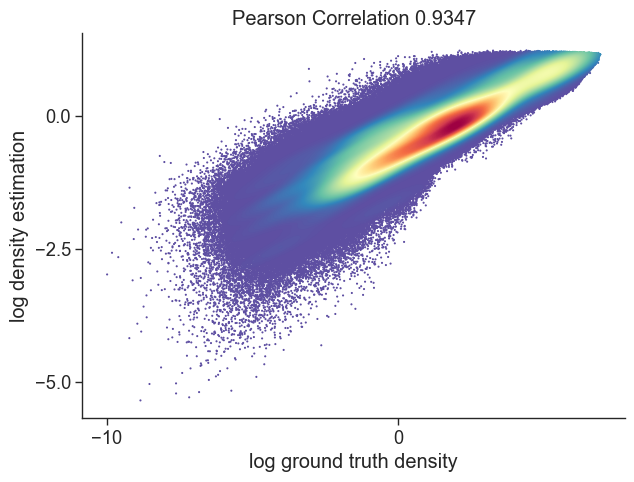

In [11]:
xy = np.vstack([np.ravel(x), np.ravel(y)])
idx = np.random.choice(xy.shape[1], size=500)
z = gaussian_kde(xy[:, idx])(xy)
i = np.argsort(z)
scp = plt.scatter(y[i], x[i], c=z[i], s=.5)
plt.locator_params(axis="x", nbins=3)
plt.locator_params(axis="y", nbins=3)
#plt.ylim(*np.quantile(x, [.001, 1]))
plt.ylabel('log density estimation')
plt.xlabel('log ground truth density')
#plt.colorbar(scp)
#plt.axis('on')
matplotlib.rcParams['axes.spines.bottom'] = "on"
matplotlib.rcParams['axes.spines.left'] = "on"
plt.title(f'Pearson Correlation {ccor:.4}')
plt.show()
matplotlib.rcParams['axes.spines.bottom'] = "off"
matplotlib.rcParams['axes.spines.left'] = "off"

# Save Result

In [12]:
filename = "latentX_10M_single_core.h5ad"
#sim_ad.write(filename)
filepath = os.path.join(os.getcwd(), filename)
print(f'Saved at {filepath}')

Saved at /fh/fast/setty_m/user/dotto/simulated_datasets/cd34_like_10d_v1/latentX_10M_single_core.h5ad


# Load and continue

In [6]:
filename = "latentX_10M_single_core.h5ad"
filepath = os.path.join(os.getcwd(), filename)
sim_ad = sc.read(filepath)

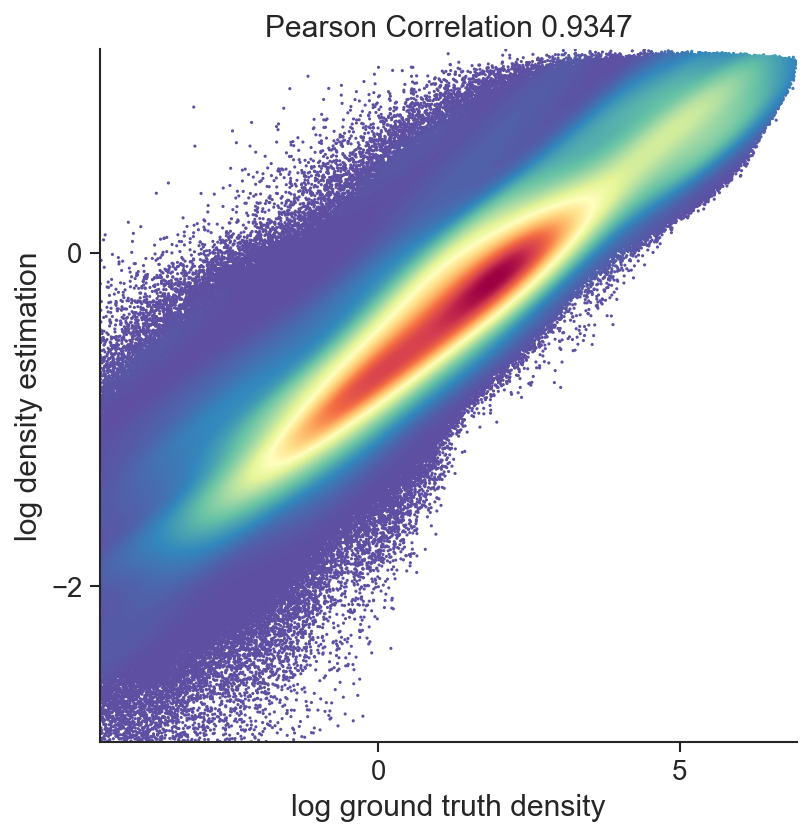

In [6]:
x = sim_ad.obs['log_density']/np.log(10)
y = np.log10(sim_ad.obs['ground_truth'] * sim_ad.n_obs)
ccor = np.corrcoef(y, x)[1, 0]
xy = np.vstack([np.ravel(x), np.ravel(y)])
idx = np.random.choice(xy.shape[1], size=500)
z = gaussian_kde(xy[:, idx])(xy)
i = np.argsort(z)
scp = plt.scatter(y[i], x[i], c=z[i], s=.5)
plt.locator_params(axis="x", nbins=3)
plt.locator_params(axis="y", nbins=3)
plt.ylim(*np.quantile(x, [.0002, 1]))
plt.xlim(*np.quantile(y, [0.002, 1]))
plt.ylabel('log density estimation')
plt.xlabel('log ground truth density')
#plt.colorbar(scp)
#plt.axis('on')
matplotlib.rcParams['axes.spines.bottom'] = "on"
matplotlib.rcParams['axes.spines.left'] = "on"
plt.title(f'Pearson Correlation {ccor:.4}')
plt.show()
matplotlib.rcParams['axes.spines.bottom'] = "off"
matplotlib.rcParams['axes.spines.left'] = "off"

In [7]:
%%time
sc.pp.neighbors(sim_ad, n_neighbors=30)
sc.tl.umap(sim_ad)
#sc.tl.leiden(sim_ad)
sim_ad

/fh/fast/setty_m/user/dotto/mamba/envs/mellon_v2/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/fh/fast/setty_m/user/dotto/mamba/envs/mellon_v2/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/fh/fast/setty_m/user/dotto/mamba/envs/mel

CPU times: user 8h 4min 35s, sys: 3h 8min 26s, total: 11h 13min 2s
Wall time: 6h 54min 55s


AnnData object with n_obs × n_vars = 10700000 × 10
    obs: 'ground_truth', 'log_ground_truth', 'branch_name', 'log_density', 'density'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

# Vizualization

In [13]:
matplotlib.rcParams['axes.spines.bottom'] = "off"
matplotlib.rcParams['axes.spines.top'] = "off"
matplotlib.rcParams['axes.spines.left'] = "off"
matplotlib.rcParams['axes.spines.right'] = "off"

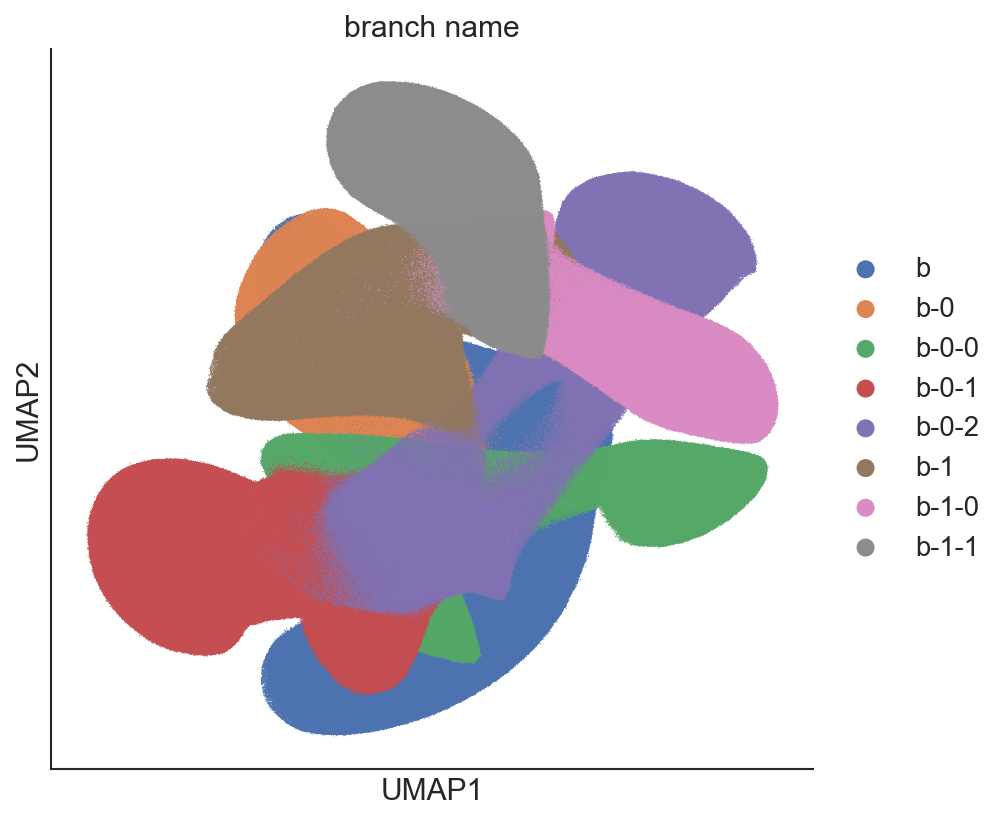

In [8]:
sc.pl.scatter(sim_ad, basis="umap", color=["branch_name"], size=1)

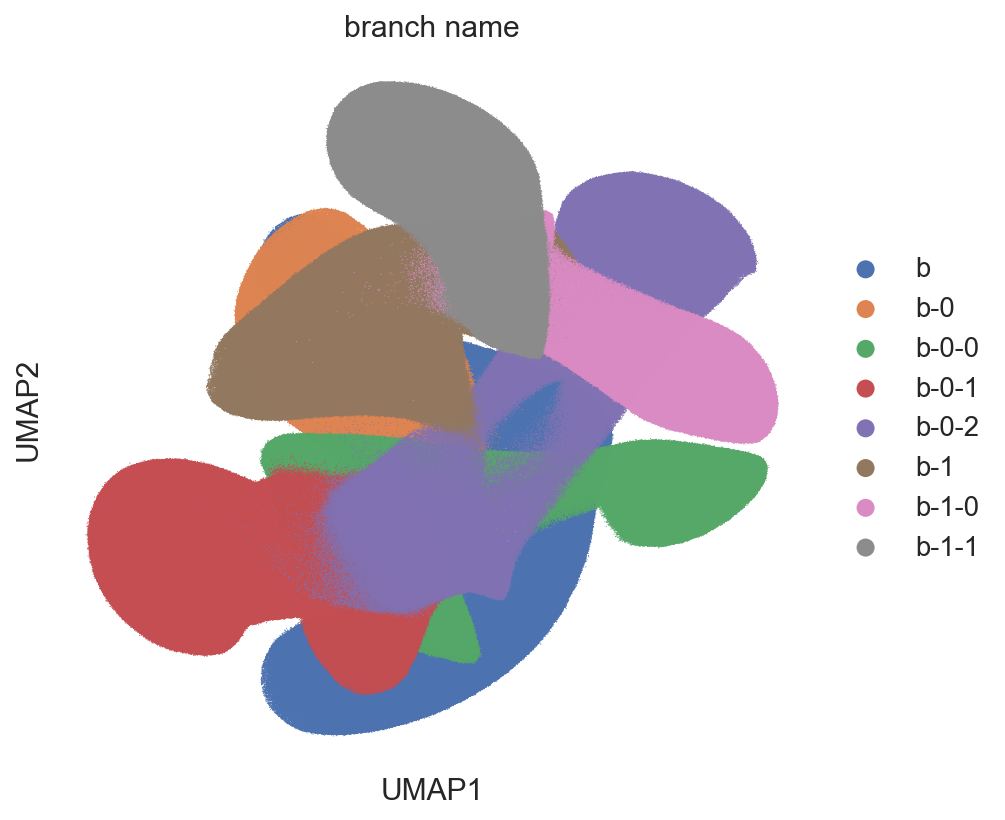

In [15]:
sc.pl.scatter(sim_ad, basis="umap", color=["branch_name"], size=1)

In [10]:
sim_ad.obs["clipped_ground_truth"] = np.clip(
    sim_ad.obs["log_ground_truth"],
    *np.quantile(sim_ad.obs["log_ground_truth"], [0.2, 1]),
)

In [11]:
sim_ad.obs["clipped_log_density"] = np.clip(
    sim_ad.obs["log_density"],
    *np.quantile(sim_ad.obs["log_density"], [0.2, 1]),
)

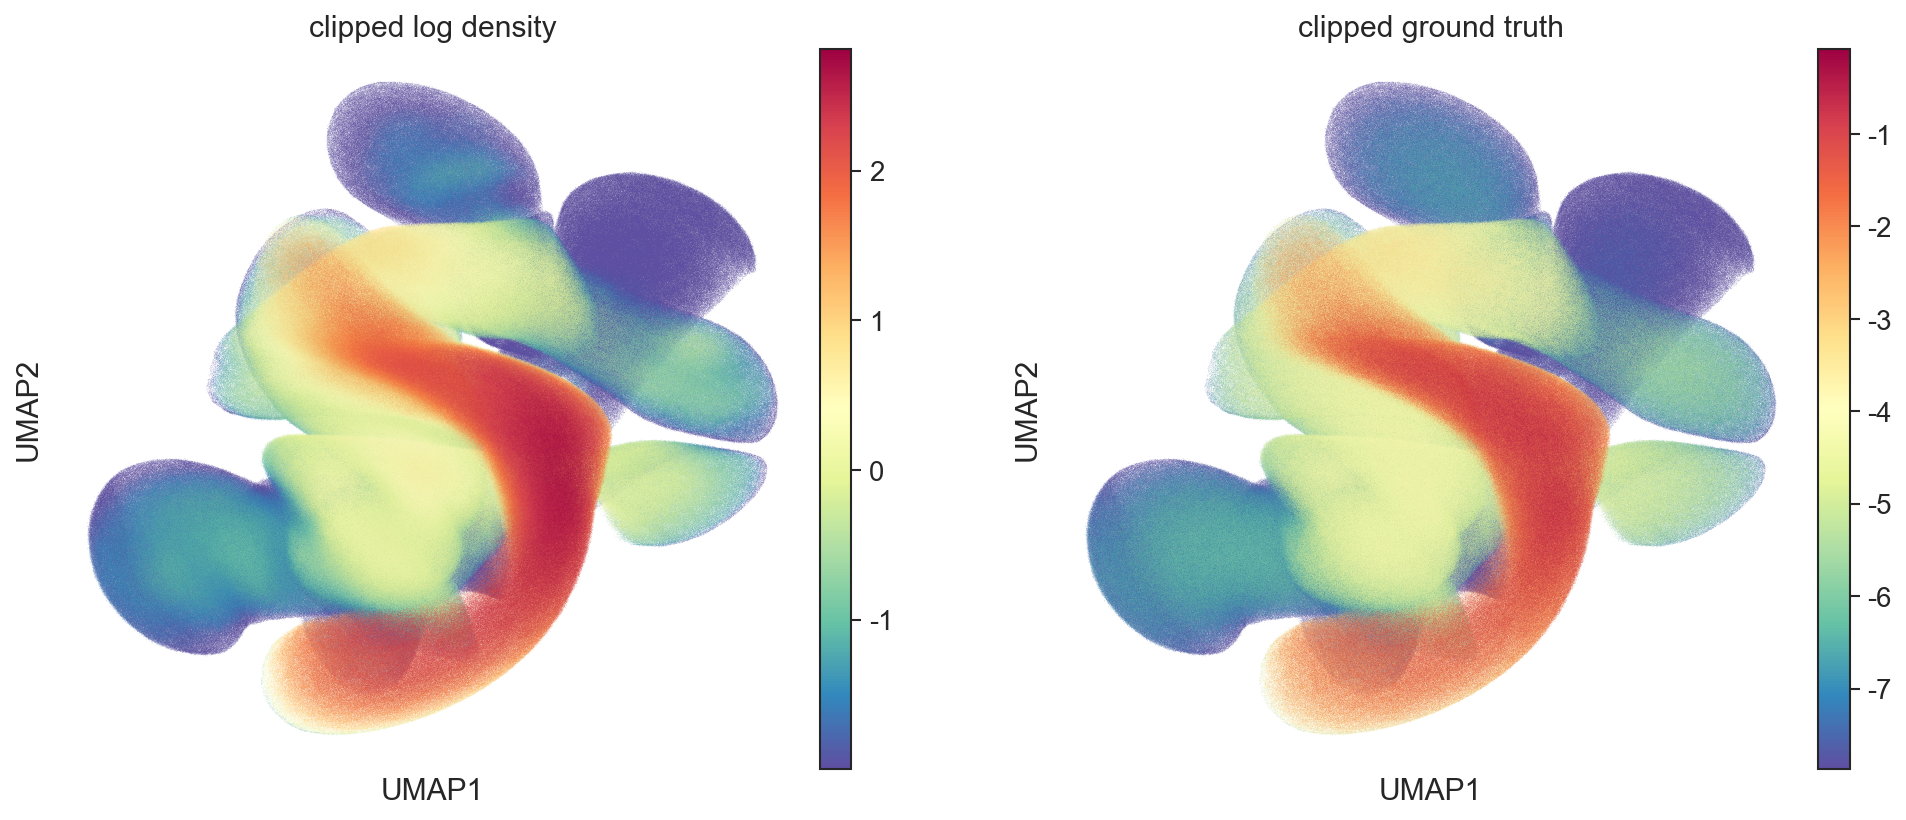

In [14]:
sc.pl.scatter(
    sim_ad,
    basis="umap",
    color=["clipped_log_density", "clipped_ground_truth"],
    color_map="Spectral_r",
    size=.1,
)

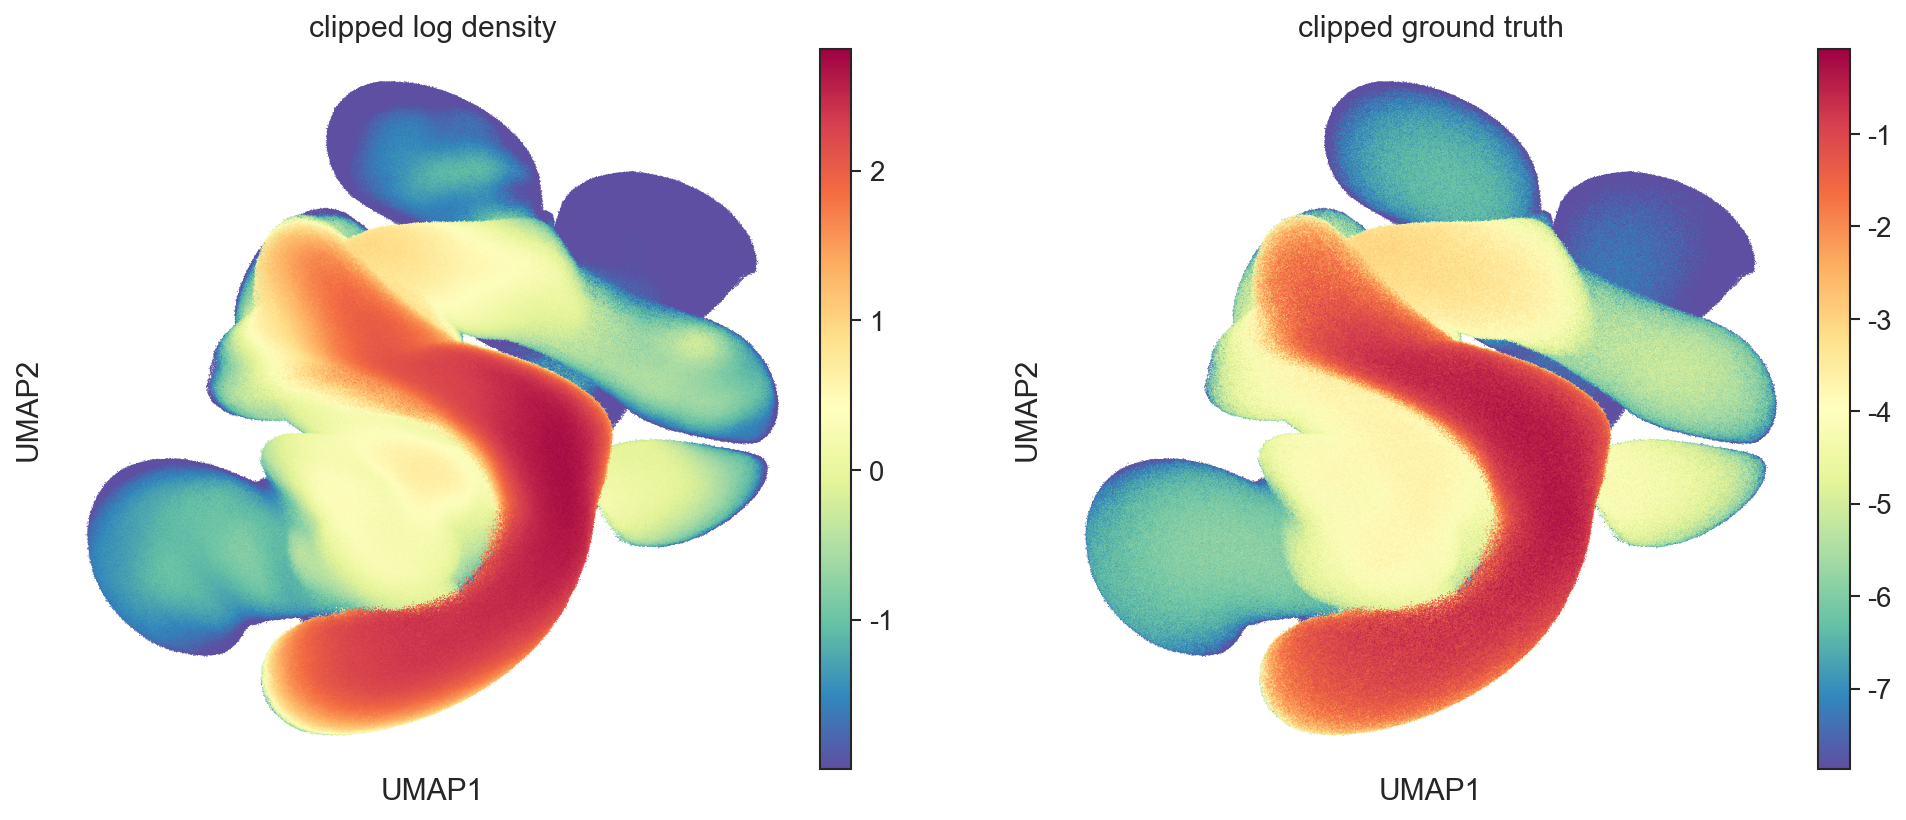

In [16]:
sc.pl.scatter(
    sim_ad,
    basis="umap",
    color=["clipped_log_density", "clipped_ground_truth"],
    color_map="Spectral_r",
    size=1,
)

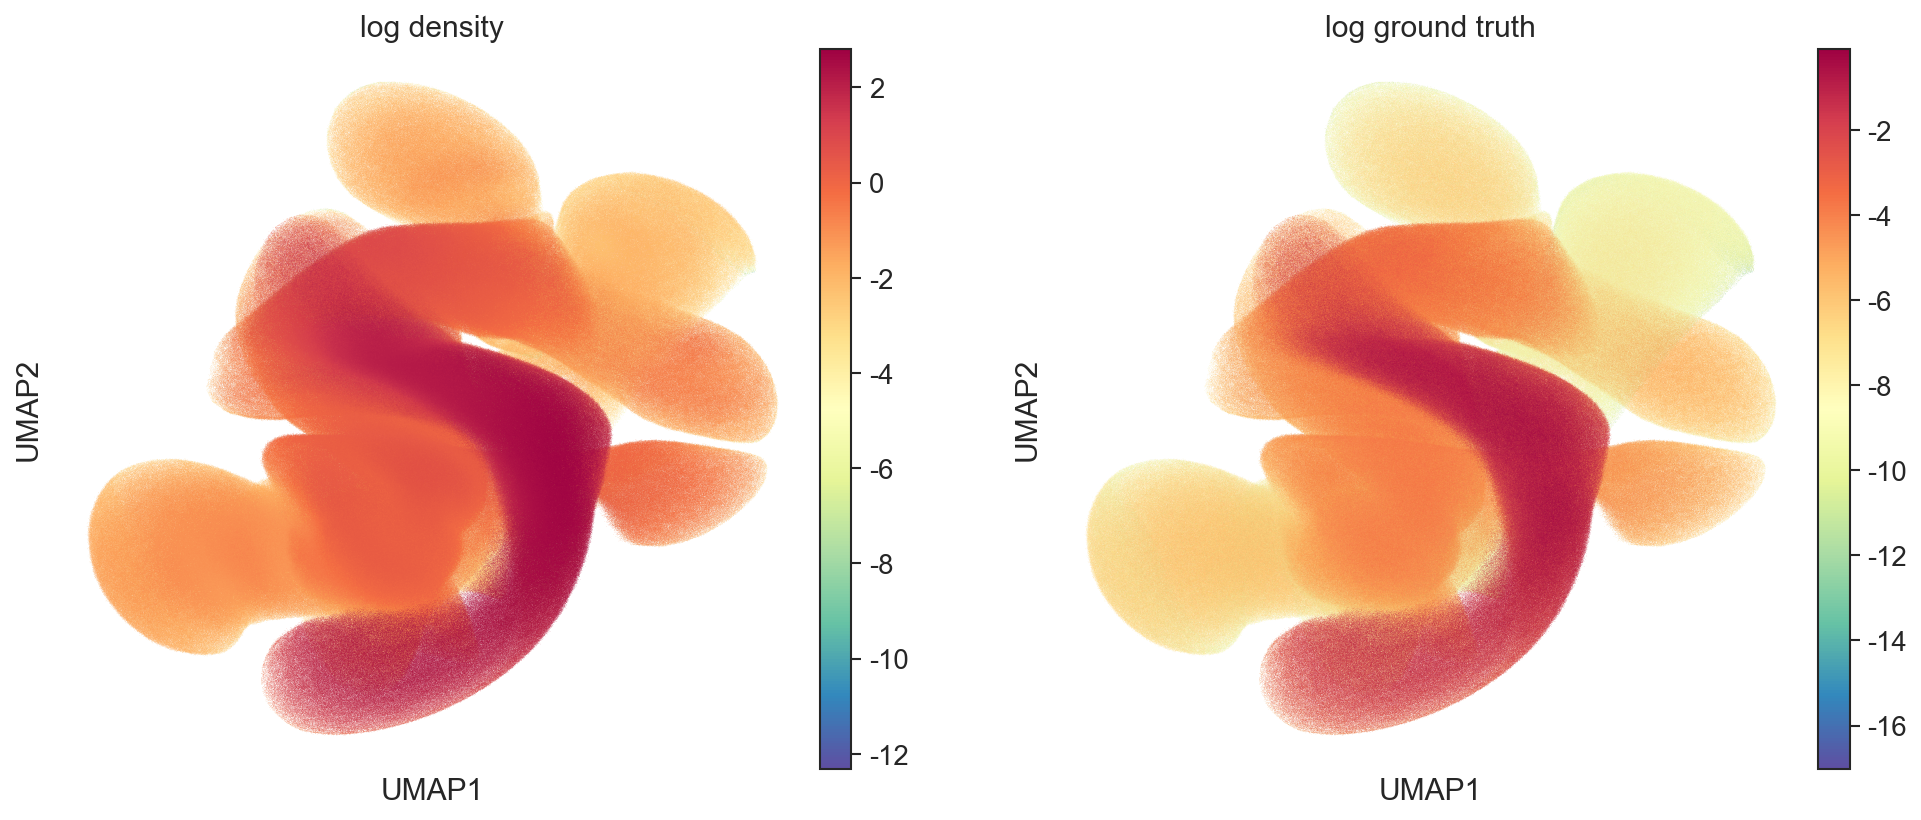

In [17]:
sc.pl.scatter(
    sim_ad,
    basis="umap",
    color=["log_density", "log_ground_truth"],
    color_map="Spectral_r",
    size=.1,
)

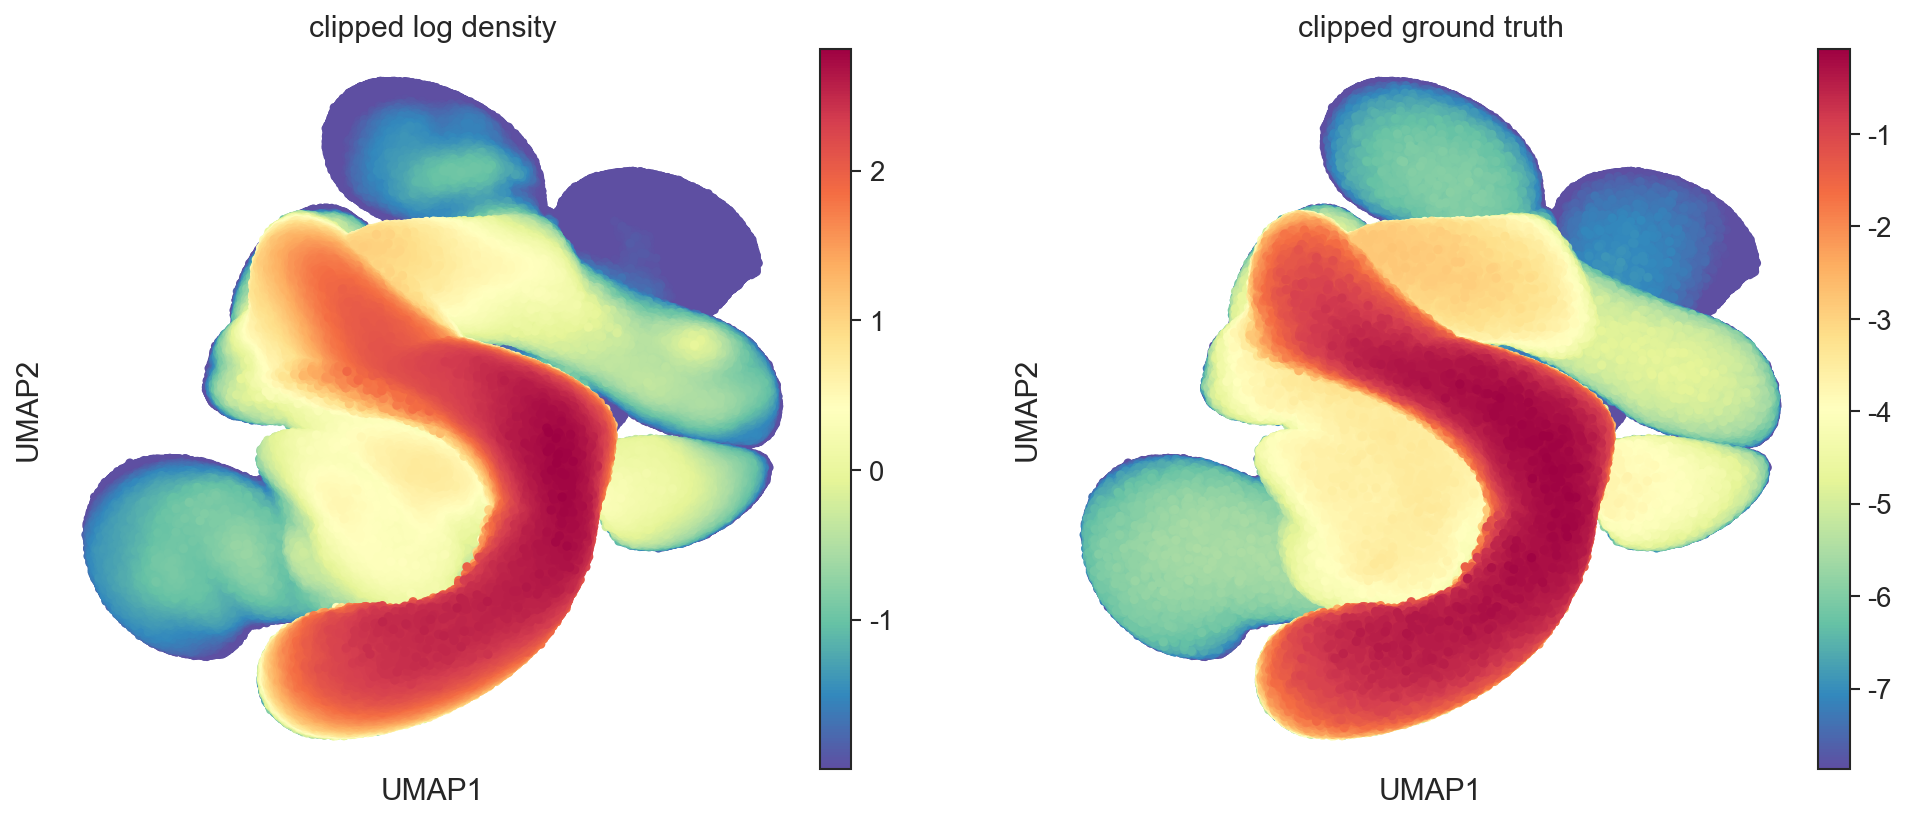

In [18]:
sim_ad.obs["clipped_log_density"] = np.clip(
    sim_ad.obs["log_density"],
    *np.quantile(sim_ad.obs["log_density"], [0.2, 1]),
)
sc.pl.scatter(
    sim_ad,
    basis="umap",
    color=["clipped_log_density", "clipped_ground_truth"],
    color_map="Spectral_r",
    size=80,
)